In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np

In [2]:
db = sqlalchemy.engine.url.URL(drivername='mysql',
                            host='127.0.0.1',
                            database='sherman_1',
                            query={'read_default_file': '~/.my.cnf', 'charset':'utf8'})
engine = sqlalchemy.create_engine(db)

In [3]:
df = pd.read_sql('''
    SELECT * FROM sherman_1.screen;
''' ,engine)

In [4]:
# merge sensor info for the same participant
df_id = pd.read_csv('/home/memari/jhu_centering/tables/id.csv')
# second device_id
l = [17,18,61,20,22,37]
l2 = set()
for index in l:
    l2.add(df_id.loc[index,'device_id2'])
# create a dict of 'device_id2':'device_id1'
my_dict = {}
for index, row in df_id.iterrows():
    if row['device_id2'] in l2:
        my_dict[row['device_id2']] = row['device_id1']
# replace
for index, row in df.iterrows():
    if row['device_id'] in my_dict:
        df.loc[index,'device_id'] = my_dict[row['device_id']]

In [5]:
def get_on_time(df):
    uniq_device_id = list(set(df['device_id'].tolist()))
    df_output = pd.DataFrame()
    for device_id in uniq_device_id:
        df_target = df[df['device_id']==device_id]
        df_target = df_target.sort_values(by = 'timestamp', ascending = False)
        past_timestamp = df_target['timestamp'].tolist()
        past_timestamp = past_timestamp[1:]+[None]
        past_status = df_target['screen_status'].tolist()
        past_status = past_status[1:]+[None]
        df_target['past_timestamp'] = past_timestamp
        df_target['past_status'] = past_status
        df_target = df_target[(df_target['screen_status']==2)&(df_target['past_status']==3)]
        if df_target.shape[0]>0:
            df_target['screen_on_time'] = df_target.apply(lambda x: (x['timestamp']-x['past_timestamp'])/1000, axis = 1)
            df_target = df_target[['device_id','timestamp','screen_on_time']]
            df_output = pd.concat([df_output, df_target], ignore_index=True)
    
    return df_output

In [6]:
df_less = get_on_time(df)
df_less

,device_id,timestamp,screen_on_time
0,98de0a59-c75e-4b1b-b80c-dd54dbfd5e07,1.673467e+12,915.701
1,98de0a59-c75e-4b1b-b80c-dd54dbfd5e07,1.673467e+12,890.659
2,98de0a59-c75e-4b1b-b80c-dd54dbfd5e07,1.673465e+12,170.578
3,98de0a59-c75e-4b1b-b80c-dd54dbfd5e07,1.673463e+12,1.232
4,98de0a59-c75e-4b1b-b80c-dd54dbfd5e07,1.673463e+12,277.615
...,...,...,...
125813,631788ed-6d66-4c1c-8b18-c2d320fd3043,1.670467e+12,10.257
125814,631788ed-6d66-4c1c-8b18-c2d320fd3043,1.670464e+12,696.527
125815,631788ed-6d66-4c1c-8b18-c2d320fd3043,1.670461e+12,43.126
125816,631788ed-6d66-4c1c-8b18-c2d320fd3043,1.670454e+12,346.330


In [7]:
df_less['date'] = pd.to_datetime(df_less['timestamp'],unit='ms').dt.date

In [8]:
df_less = df_less[['device_id','date','screen_on_time']]

In [9]:
df_output = df_less.groupby(['device_id','date']).agg(screen_on_time = ('screen_on_time', np.sum),
                                                      screen_on_freq = ('screen_on_time',len)
                                                     )
df_output = df_output.reset_index()
df_output['screen_on_freq'] = df_output['screen_on_freq'].apply(lambda x: int(x))
df_output

,device_id,date,screen_on_time,screen_on_freq
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,1831.390,11
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,5478.451,40
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,7987.292,41
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,9316.163,49
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,13422.876,58
...,...,...,...,...
2874,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,11024.756,48
2875,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,21846.925,63
2876,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,35124.968,104
2877,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,4210.308,25


In [10]:
df_output.to_csv("/home/memari/jhu_centering/tables/screen_cleaned.csv", index = False)

# filter 1-28

In [11]:
def find_first_day(device_id, df_cleaned):
    df_target = df_cleaned[df_cleaned['device_id']==device_id]
    return min(df_target['date'])

In [12]:
def get_1_to_28(df_cleaned):
    first_day = {device_id:find_first_day(device_id, df_cleaned) 
                 for device_id in set(df_cleaned['device_id'].tolist())
                if find_first_day(device_id, df_cleaned)>=datetime.date(year=2022,month=11,day=11)}
    df_cleaned = df_cleaned[df_cleaned['device_id'].isin(first_day)]
    df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_cleaned = df_cleaned[df_cleaned['day']<=28]
    return df_cleaned

In [13]:
df_cleaned_1_28 = get_1_to_28(df_output)
df_cleaned_1_28

<ipython-input-12-81973113a098>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)


,device_id,date,screen_on_time,screen_on_freq,day
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,1831.390,11,1
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,5478.451,40,2
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,7987.292,41,3
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,9316.163,49,4
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,13422.876,58,5
...,...,...,...,...,...
2874,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,11024.756,48,23
2875,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,21846.925,63,24
2876,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,35124.968,104,25
2877,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,4210.308,25,26


# lineplot

In [14]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot[['screen_on_freq','screen_on_time','day']]
df_plot = df_plot.groupby('day').mean()
df_plot = df_plot.reset_index()


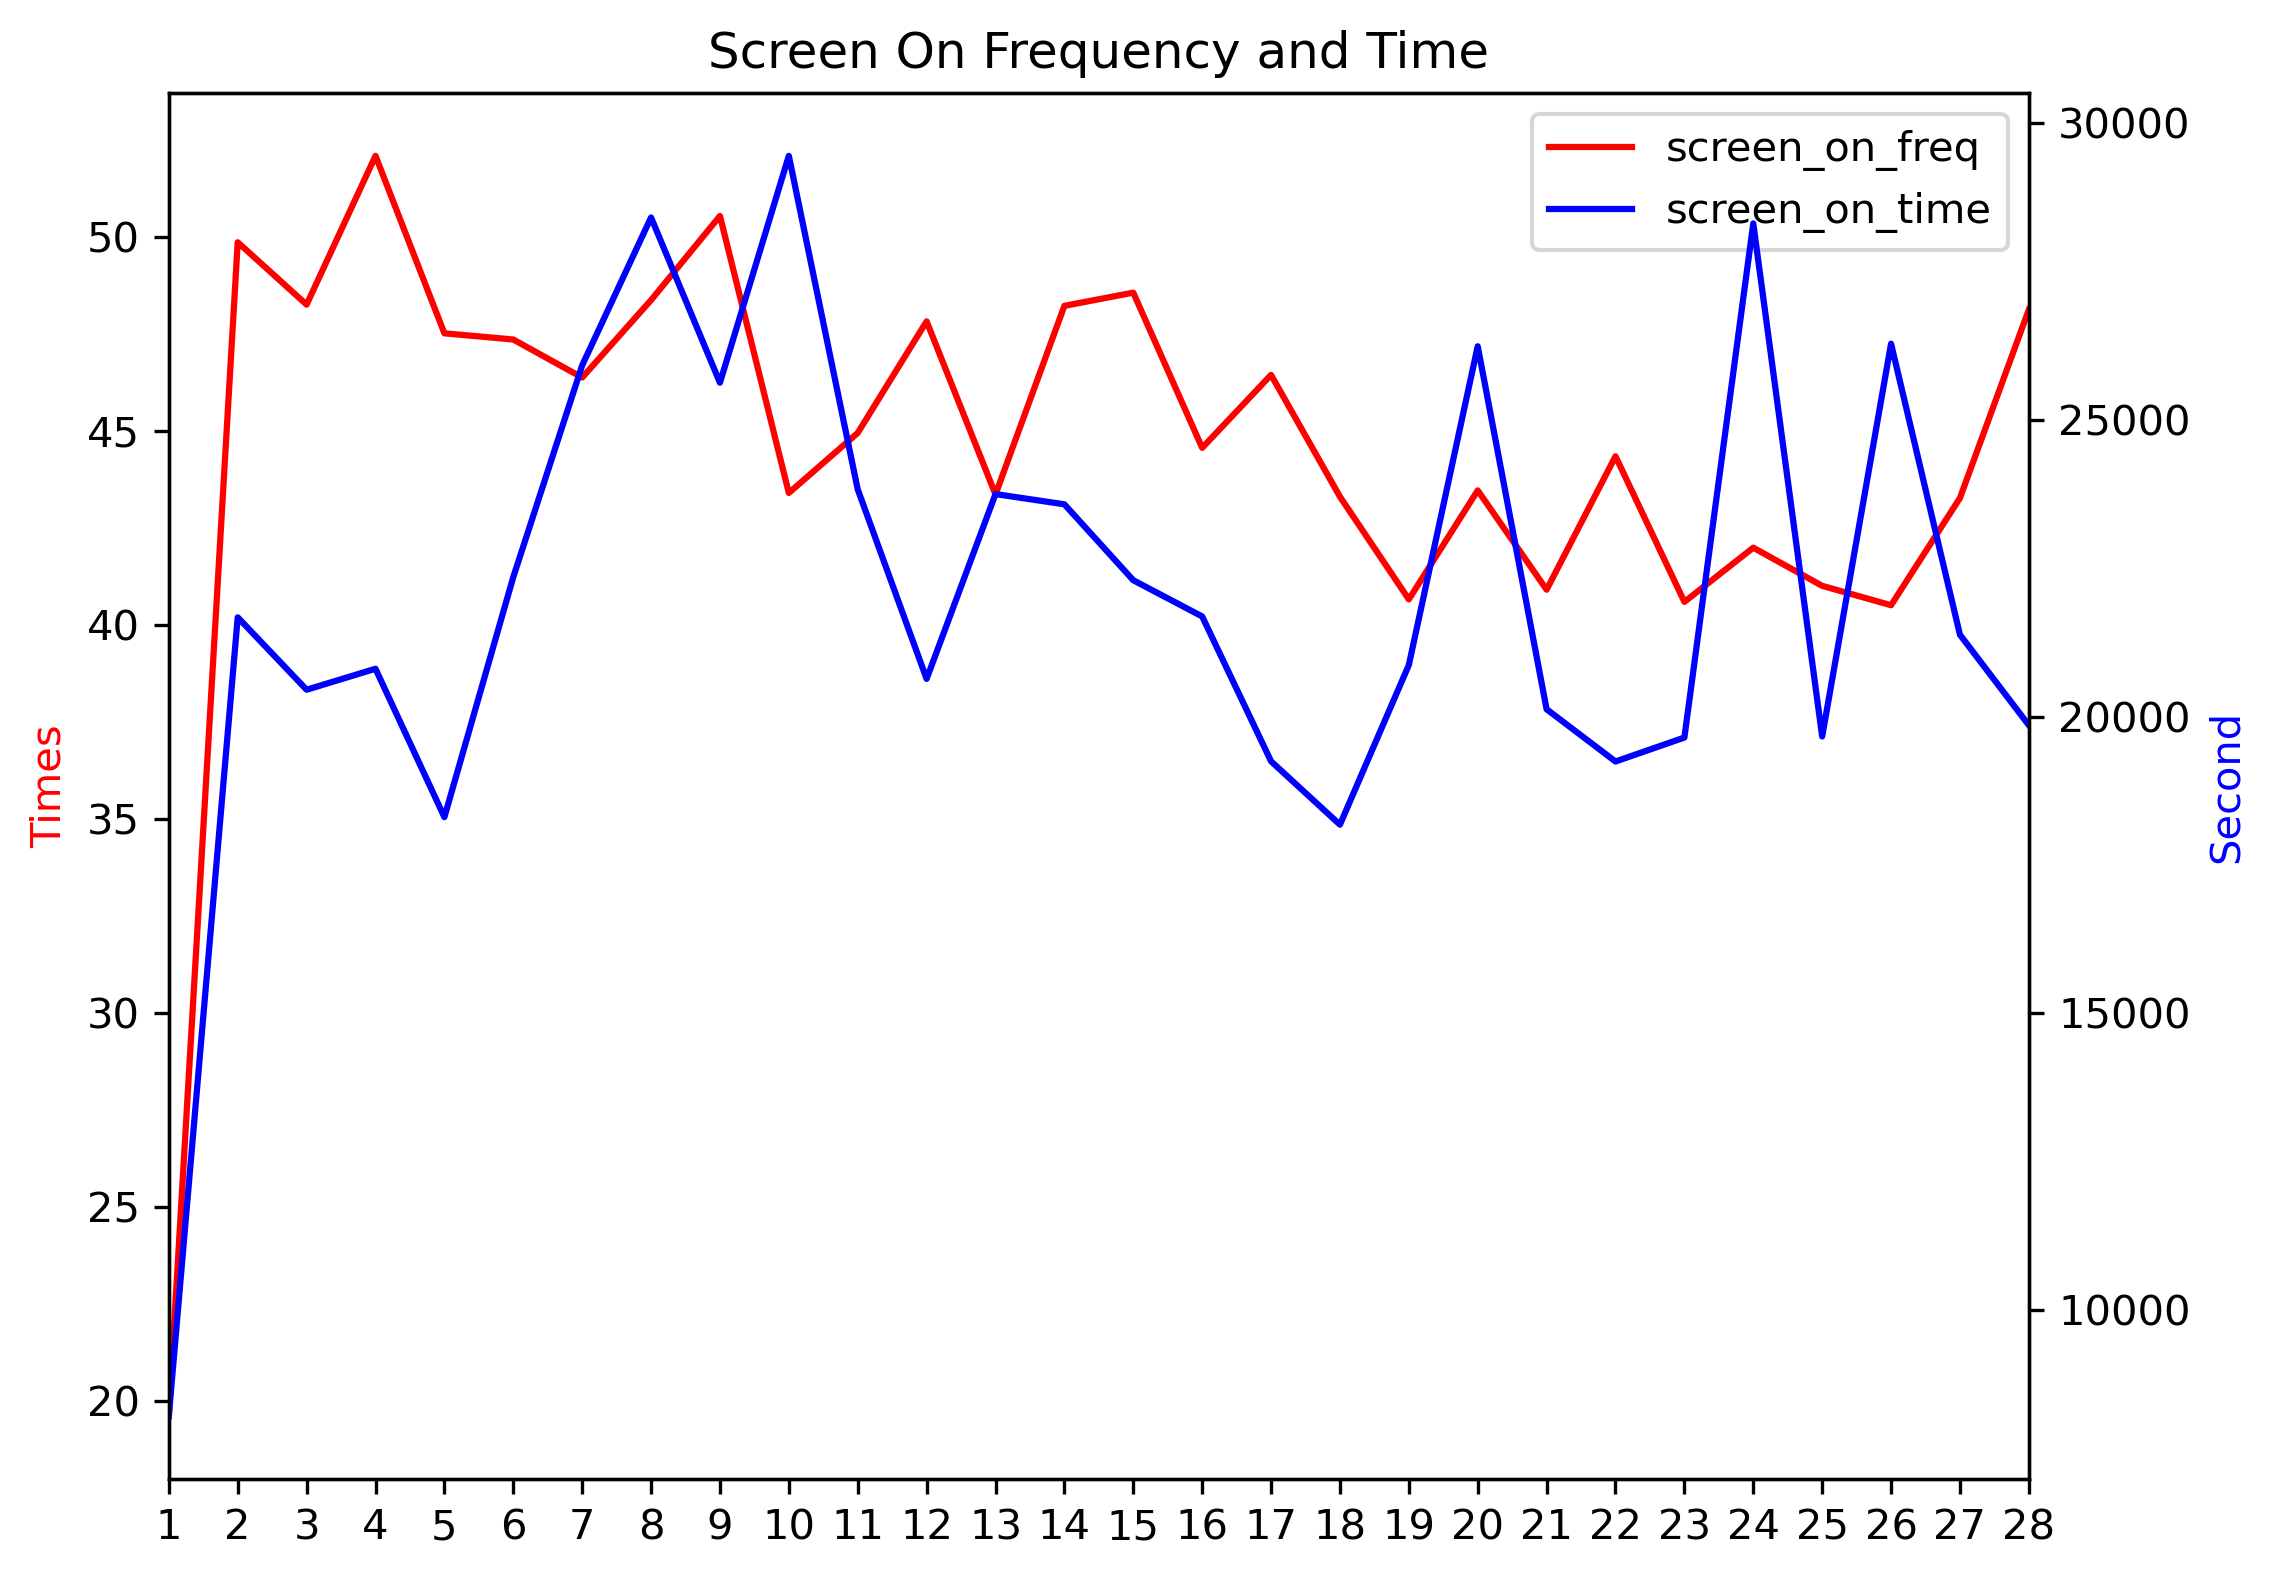

In [15]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
x = [i+1 for i in range(28)]
y1 = df_plot['screen_on_freq'].tolist()
y2 = df_plot['screen_on_time'].tolist()
ln1 = ax1.plot(x,y1,label = 'screen_on_freq', color = 'red')
ln2 = ax2.plot(x,y2,label = 'screen_on_time', color = 'blue')



plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Screen On Frequency and Time")
plt.xlabel("Days After Join")
ax1.set_ylabel('Times', color = 'red')
ax2.set_ylabel('Second', color = 'blue')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()

# group plot 

In [16]:
df_id = pd.read_csv("/data/meditation/majid/tables/id.csv")
df_id = df_id.drop_duplicates('study_id')
df_id = df_id.drop('id', axis = 1)
df_id.columns = ['device_id','Study ID']

df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv', skiprows=[1,2])[['Study ID','Group']]
df_group = df_id.merge(df_group, on = 'Study ID', how = 'left')
df_group

,device_id,Study ID,Group
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477,Experimental Condition
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959,Active Control
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307,Active Control
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016,Active Control
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895,Passive Control
...,...,...,...
64,780c9b18-72d3-4714-858d-3c91b3719155,21788465,Active Control
65,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236,Passive Control
66,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645,Experimental Condition
67,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342,Passive Control


In [17]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['screen_on_freq','screen_on_time','day','Group']]
df_plot = df_plot.groupby(['Group','day']).mean()
df_plot = df_plot.reset_index()
df_plot

,Group,day,screen_on_freq,screen_on_time
0,Active Control,1,18.450000,11291.025600
1,Active Control,2,55.550000,20673.776450
2,Active Control,3,56.700000,19357.432750
3,Active Control,4,60.800000,20591.570050
4,Active Control,5,51.315789,18611.550211
...,...,...,...,...
79,Passive Control,24,40.000000,48635.977588
80,Passive Control,25,42.125000,25029.385313
81,Passive Control,26,41.588235,36790.099765
82,Passive Control,27,45.294118,28678.762471


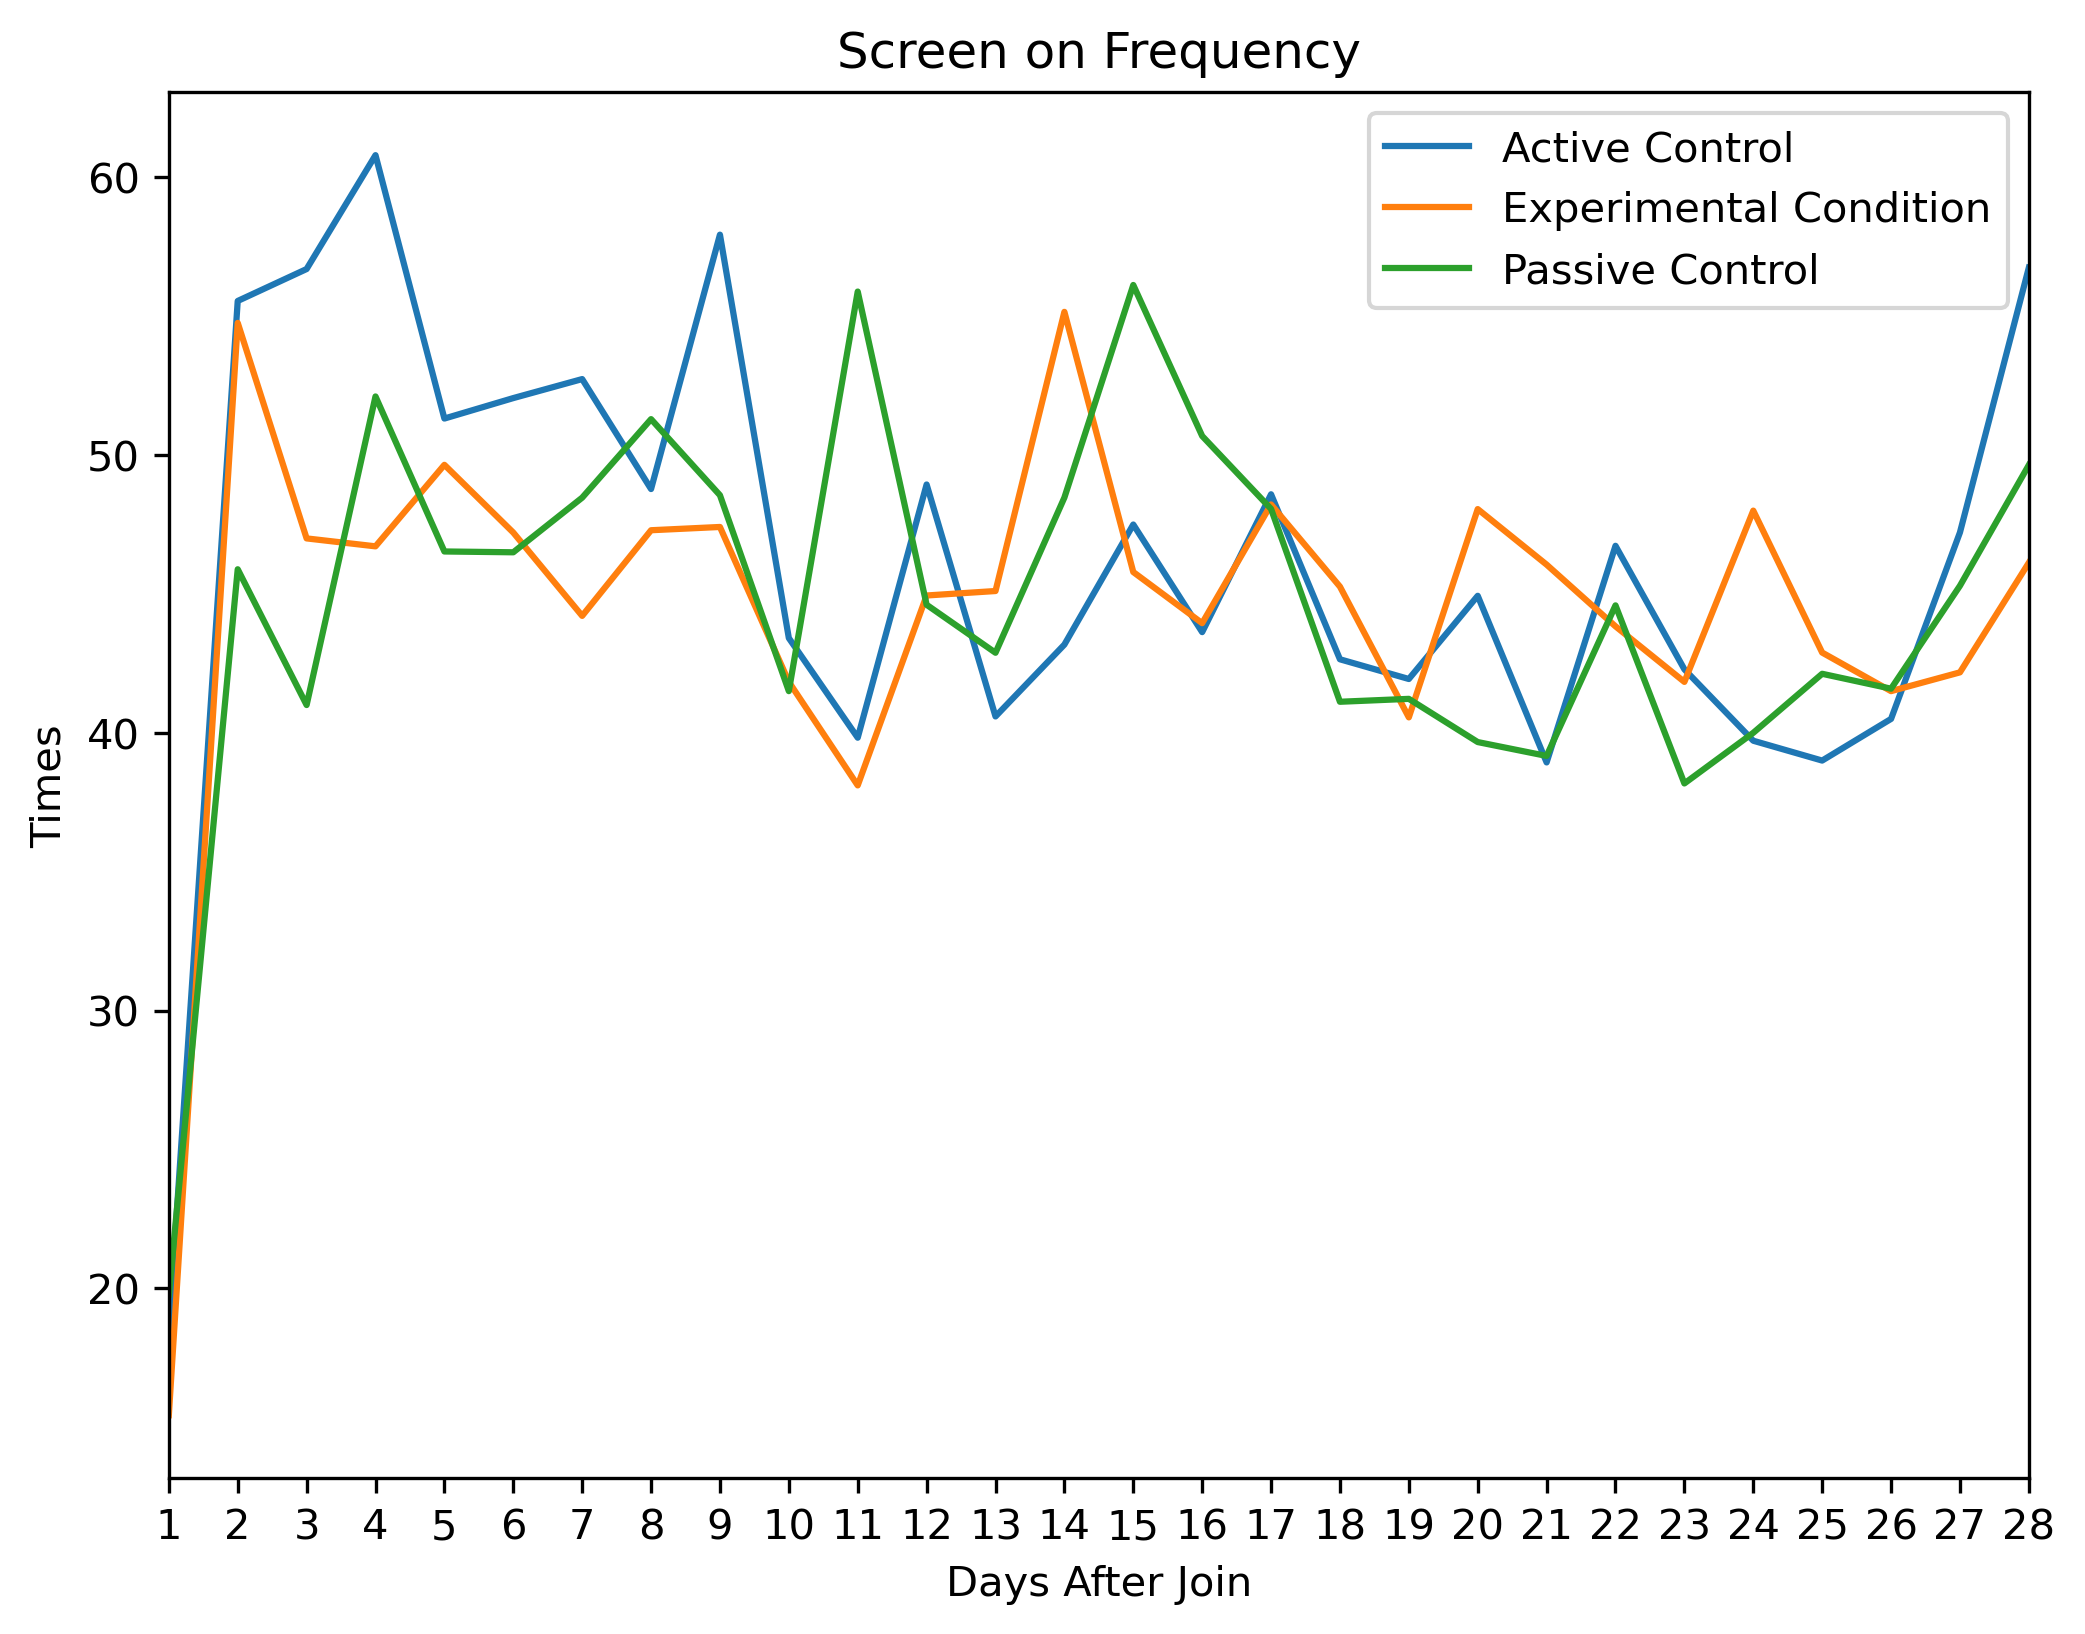

In [18]:
plt.figure(figsize=(8, 6), dpi=300)
for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
    df_target = df_plot[df_plot['Group']==group]
    x = [i+1 for i in range(28)]
    y = df_target["screen_on_freq"].tolist()
    plt.plot(x,y,label = group)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Screen on Frequency")
plt.xlabel("Days After Join")
plt.ylabel('Times')
plt.legend()
plt.show()

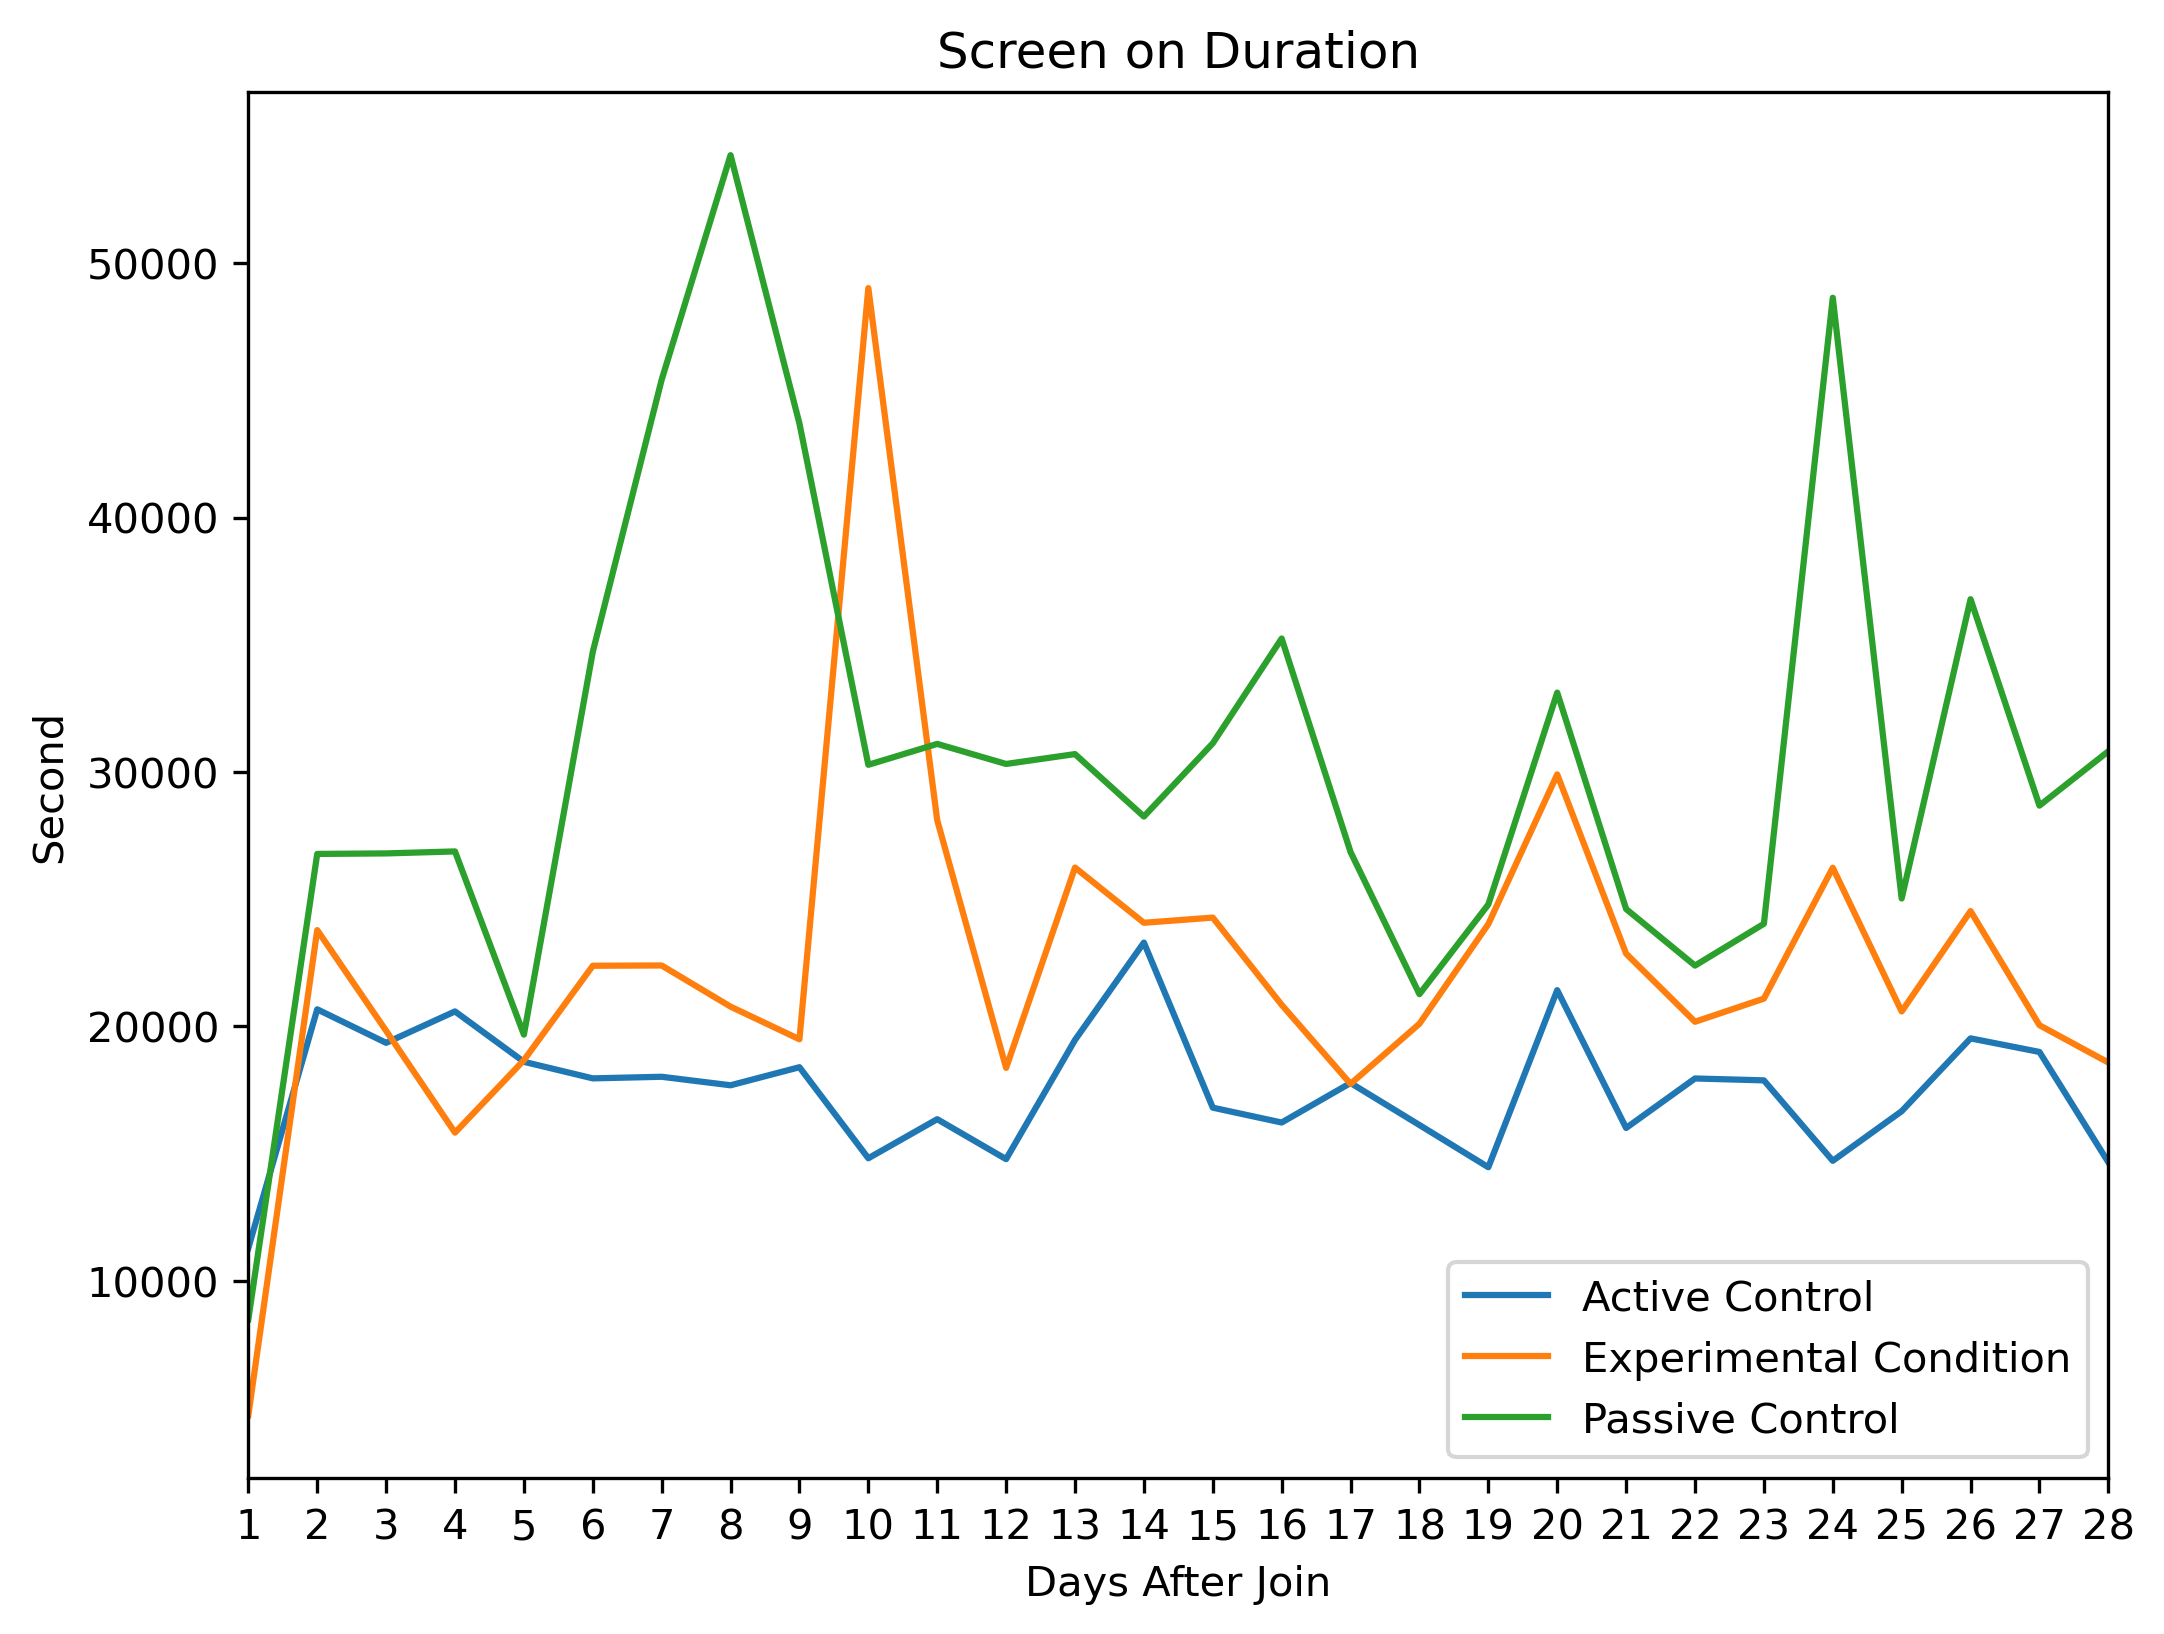

In [19]:
plt.figure(figsize=(8, 6), dpi=300)
for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
    df_target = df_plot[df_plot['Group']==group]
    x = [i+1 for i in range(28)]
    y = df_target["screen_on_time"].tolist()
    plt.plot(x,y,label = group)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Screen on Duration")
plt.xlabel("Days After Join")
plt.ylabel('Second')
plt.legend()
plt.show()